<a href="https://colab.research.google.com/github/IgorCzudy/whatsapp_message_clasterization/blob/main/notebooks/GC_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install transformers datasets evaluate
! pip install accelerate -U
! pip install peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.7/174.7 kB 2.7 MB/s eta 0:00:00


# Prepare data

In [2]:
import pandas as pd
music_aug = pd.read_csv("https://raw.githubusercontent.com/IgorCzudy/whatsapp_message_clasterization/main/finalData/music_augmented.csv")
party_aug = pd.read_csv("https://raw.githubusercontent.com/IgorCzudy/whatsapp_message_clasterization/main/finalData/party_augmented.csv")
full = pd.read_csv("https://raw.githubusercontent.com/IgorCzudy/whatsapp_message_clasterization/main/CleanChats/FullChat.csv")

In [3]:
full.rename(columns={"Message": "message", "Section": "section"}, inplace=True)

In [4]:
full = full.drop(columns=["Date", "Time", "Sender"])

sections = ["Football", "Music", "Party","General"]
final_df = full[full["section"].isin(sections)]

music_aug["section"] = "Music"
party_aug["section"] = "Party"

final_df = pd.concat([final_df, music_aug, party_aug])

In [5]:
# remove duplicates
final_df = final_df.drop_duplicates()
final_df = final_df.reset_index(drop=True)

In [6]:
final_df["section"].value_counts()

Football    3415
Party       2715
General     2636
Music       1480
Name: section, dtype: int64

In [7]:
final_df=final_df.rename(columns={'section': 'label','message':'text'})
final_df['label'] = final_df['label'].replace('General', 0)
final_df['label'] = final_df['label'].replace('Football', 1)
final_df['label'] = final_df['label'].replace('Party', 2)
final_df['label'] = final_df['label'].replace('Music', 3)
final_df.head()

,text,label
0,Someone going to the beach this afternoon?,0
1,We'll be a few minutes late \nSiuuuuuuu,0
2,locatie: https://maps.google.com/?q=39.473291...,0
3,"Hii, I also will be a few minutes late for th...",0
4,Me too,0


## Tokenize

In [8]:
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from datasets import Dataset

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

data = Dataset.from_pandas(final_df)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
tokenized_dataset = data.map(preprocess_function, batched=True)


data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/10246 [00:00<?, ? examples/s]

In [9]:
tokenized_dataset[0]


{'text': ' Someone going to the beach this afternoon?',
 'label': 0,
 'input_ids': [101, 2619, 2183, 2000, 1996, 3509, 2023, 5027, 1029, 102],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [10]:

# column we want to stratify with respect to
stratify_column_name = "label"
# create class label column and stratify
splits = tokenized_dataset.class_encode_column(stratify_column_name).train_test_split(test_size=0.2,stratify_by_column=stratify_column_name)
dataset_train = splits["train"]
dataset_test = splits["test"]
print(f"Train : {dataset_train}")
print(f"Test : {dataset_test}")

Stringifying the column:   0%|          | 0/10246 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/10246 [00:00<?, ? examples/s]

Train : Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 8196
})
Test : Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 2050
})


# Model

In [11]:
# track accuracy during training
import numpy as np
import evaluate

accuracy = evaluate.load("accuracy")
recall = evaluate.load("recall")
f1m = evaluate.load("f1")
precision = evaluate.load("precision")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    acc = accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    rc = recall.compute(predictions=predictions, references=labels,average='macro')["recall"]
    f1 = f1m.compute(predictions=predictions, references=labels,average='macro')["f1"]
    pcs = precision.compute(predictions=predictions, references=labels,average='macro')["precision"]
    return {"accuracy":acc,"precision":pcs,"recall":rc,"f1":f1}

# Login to publish model to hugginface


In [12]:
from huggingface_hub import notebook_login

notebook_login()

In [13]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from peft import get_peft_config, PeftModel, PeftConfig, get_peft_model, LoraConfig, TaskType

id2label = {0: "GENERAL", 1: "FOOTBALL", 2: "PARTY", 3: "MUSIC"}
label2id = {"GENERAL": 0, "FOOTBALL": 1, "PARTY": 2, "MUSIC": 3}

model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=4, id2label=id2label, label2id=label2id
)

def print_trainable_parameters(model):
  """
  Prints the number of trainable parameters in the model.
  """
  trainable_params = 0
  all_param = 0
  for _, param in model.named_parameters():
    all_param += param.numel()
    if param.requires_grad:
      trainable_params += param.numel()
  print(
      f"trainable params: {trainable_params} || all params: {all_param} || trainables%: {100 * trainable_params / all_param}"
  )
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, inference_mode=False, r=16, lora_alpha=32, lora_dropout=0.1
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
model = get_peft_model(model, peft_config)
print_trainable_parameters(model)

trainable params: 592900 || all params: 110078216 || trainables%: 0.5386170139239902


In [ ]:
training_args = TrainingArguments(
    output_dir="whatsapp-group-classifierv3",
    learning_rate=4e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=30,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.959800,0.655311,0.736585,0.772445,0.728009,0.727976
2,0.651700,0.571804,0.775122,0.788814,0.780181,0.781722
3,0.570700,0.513416,0.802439,0.821407,0.805934,0.811492
4,0.524600,0.487364,0.814634,0.837600,0.815091,0.824278
5,0.477300,0.471672,0.821463,0.841677,0.829547,0.834422
6,0.451200,0.458641,0.824390,0.846457,0.833019,0.838915
7,0.449600,0.453363,0.833171,0.853755,0.838048,0.845020
8,0.416400,0.443153,0.836585,0.861476,0.841206,0.850076
9,0.418400,0.439609,0.835610,0.860127,0.840722,0.849320
10,0.407500,0.434565,0.833171,0.856274,0.841828,0.848035


TrainOutput(global_step=15390, training_loss=0.4022348677825432, metrics={'train_runtime': 2273.1107, 'train_samples_per_second': 108.169, 'train_steps_per_second': 6.77, 'total_flos': 7580030406774912.0, 'train_loss': 0.4022348677825432, 'epoch': 30.0})

To publish to hugginface need login with the access token

In [ ]:
trainer.push_to_hub()

'https://huggingface.co/DTempo/whatsapp-group-classifierv3/tree/main/'

## Inference

In [ ]:
import torch
def classify_text(model, tokenizer, texts):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    predicted_scores, predicted_classes = torch.max(probabilities, dim=1)
    results = []
    for i in range(len(texts)):
        result = {
            "label": id2label[predicted_classes[i].item()],
            "score": predicted_scores[i].item()
        }
        results.append(result)
    return results
id2label = {0: "GENERAL", 1: "FOOTBALL", 2: "PARTY", 3: "MUSIC"}
label2id = {"GENERAL": 0, "FOOTBALL": 1, "PARTY": 2, "MUSIC": 3}

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import pipeline
import transformers
from peft import get_peft_config, PeftModel, PeftConfig, get_peft_model, LoraConfig, TaskType

peft_model_id = "Dtempo/whatsapp-group-classifierv3"
config = PeftConfig.from_pretrained(peft_model_id)
inference_model = AutoModelForSequenceClassification.from_pretrained(
    config.base_model_name_or_path, num_labels=4, id2label=id2label, label2id=label2id
)
tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)
model = PeftModel.from_pretrained(inference_model, peft_model_id)
prompts = ["Hey everyone! There's a jazz concert at Jimmy Glass Jazz Bar this Friday night. Who's up for some  tunes?",
    "Lest go do some running tomorrow ",
    "Hello, any plans for tonight? I heard Bamboo Pub has a free entry until 00:30. What do you think?",
    "Anyone knows how to get the ESN card?"
]
results = classify_text(inference_model, tokenizer, prompts)
for i, result in enumerate(results):
    print(f"Prompt {i + 1}: {prompts[i]}")
    print(f"Result: {result}")

adapter_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


adapter_model.safetensors:   0%|          | 0.00/2.38M [00:00<?, ?B/s]

Prompt 1: Hey everyone! There's a jazz concert at Jimmy Glass Jazz Bar this Friday night. Who's up for some  tunes?
Result: {'label': 'MUSIC', 'score': 0.9981642365455627}
Prompt 2: Lest go do some running tomorrow 
Result: {'label': 'FOOTBALL', 'score': 0.9804179668426514}
Prompt 3: Hello, any plans for tonight? I heard Bamboo Pub has a free entry until 00:30. What do you think?
Result: {'label': 'PARTY', 'score': 0.9983152151107788}
Prompt 4: Anyone knows how to get the ESN card?
Result: {'label': 'GENERAL', 'score': 0.9529610276222229}


# Evaluation - Datasets

adapter_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


adapter_model.safetensors:   0%|          | 0.00/2.38M [00:00<?, ?B/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


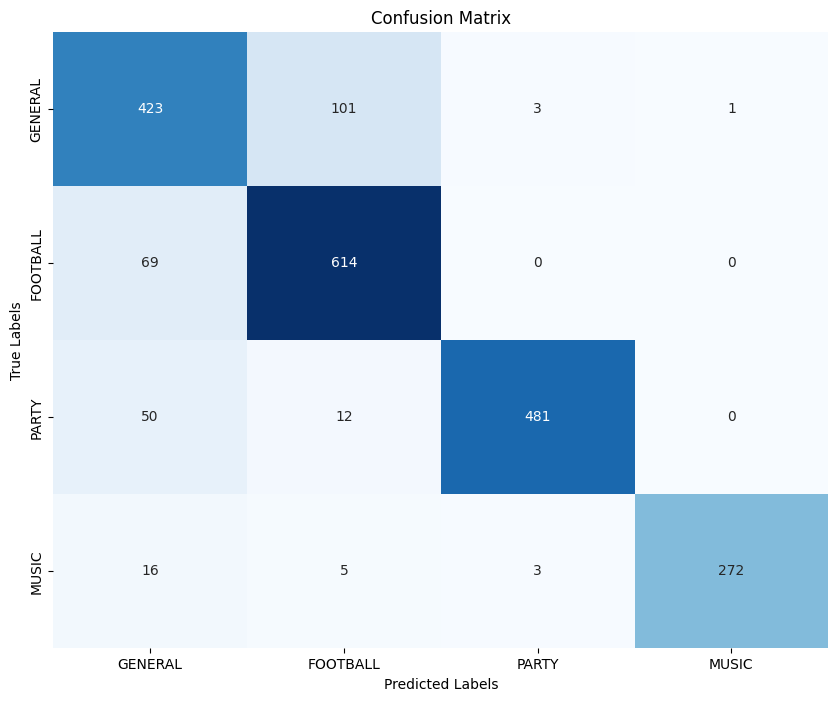

In [15]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import pipeline
import transformers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
from peft import get_peft_config, PeftModel, PeftConfig, get_peft_model, LoraConfig, TaskType
# track accuracy during training
import numpy as np
import evaluate

peft_model_id = "Dtempo/whatsapp-group-classifierv3"
config = PeftConfig.from_pretrained(peft_model_id)
inference_model = AutoModelForSequenceClassification.from_pretrained(
    config.base_model_name_or_path, num_labels=4, id2label=id2label, label2id=label2id
)

tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)
model = PeftModel.from_pretrained(inference_model, peft_model_id)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    data_collator=data_collator,
)
#prediction
result= trainer.predict(dataset_test)
predictions = np.argmax(result.predictions, axis=1)

# Assuming result.label_ids is the true labels
true_labels = result.label_ids

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
# Convert the confusion matrix to a pandas DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix, index=id2label.values(), columns=id2label.values())

plt.figure(figsize=(10, 8))
sn.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()